In [1]:
import numpy as np
import pandas as pd
import math
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
seed = 42
np.random.seed(seed)

In [3]:
def get_real_distribution():
    """
    generate a dataframe with the mean of the number of births in america from 1994 to 2003
    :return: dataframe with 1 column for the birth rate
    """

    df = pd.read_csv("US_births_1994-2003_CDC_NCHS.csv")
    feb29 = df[(df["date_of_month"] == 29) & (df["month"] == 2)].index.to_numpy()
    df.drop(feb29)  # remove the 29th of February
    df = (
        df.groupby(['month', 'date_of_month'])
            .births
            .mean()
    )
    df = pd.DataFrame(df.values, columns=["births"])

    return df

In [4]:
def compute_average(k, n, seed, distribution=None, real=False):
    """
    compute the average trials needed to have a collision
    :param k: number of runs
    :param n: cardinality of the set
    :param seed: random seed
    :param distribution: dataframe with the birth distribution
    :param real: specify the type of the distribution, can be True for the real distribution or False for the uniform one
    :return: list of number of element extracted to have a collision for each run
    """

    if real and distribution is None:
        print("distribution missing")
        return -1

    np.random.seed(seed)  # set random seed
    collision_list = []
    for i in range(k):
        l = []
        m = 0
        while True:
            if real:
                x = distribution.sample(1, weights="births", replace=True).index.values  # extract a number between 0 and n from the real distribution
            else:
                x = np.random.randint(0, n)  # extract a number between 0 and n from a uniform distribution

            if x in l:
                collision_list.append(m)  # if there is a collision save the number of times it took to have one
                break

            l.append(x)  # if there is no collision add the new value to the list and continue
            m += 1  # increase counter

    return collision_list

In [5]:
def compute_probability(m, n, k, seed, distribution=None, real=False):
    """
    compute the probability of collision of m elements in a set of cardinality n
    :param m: number of elements
    :param n: cardinality of the set
    :param k: number of runs
    :param seed: random seed
    :param distribution: dataframe with the birth distribution
    :param real: specify the type of the distribution, can be True for the real distribution or False for the uniform one
    :return: probability of having a collision
    """

    if real and distribution is None:
        print("distribution missing")
        return -1

    np.random.seed(seed)  # set random seed
    collisions = 0
    for i in range(k):
        if real:
            x = distribution.sample(m, weights="births", replace=True).index.values  # extract m number between 0 and n from the real distribution
        else:
            x = np.random.randint(0, n, m)  # extract m number between 0 and n from a uniform distribution

        if len(np.unique(x)) < len(x):  # if there is a collision increment counter
            collisions += 1

    return collisions / k

In [6]:
def compute_probability_multiple_types(a, b, n, k, seed, distribution=None, real=False):
    """
    compute the probability of collision between at least one member of group1 and one member of
    group2 in a set of cardinality n
    :param a: number of type1
    :param b: number of type2
    :param n: cardinality of the set
    :param k: number of runs
    :param seed: random seed
    :param distribution: dataframe with the birth distribution
    :param real: specify the type of the distribution, can be True for the real distribution or False for the uniform one
    :return: probability of having a collision
    """

    if real and distribution is None:
        print("distribution missing")
        return -1

    np.random.seed(seed)  # set random seed
    collisions = 0
    for i in range(k):
        if real:
            x_a = distribution.sample(a, weights="births", replace=True).index.values  # extract 'a' number between 0 and n from the real distribution
            x_b = distribution.sample(b, weights="births", replace=True).index.values  # extract 'b' number between 0 and n from the real distribution
        else:
            x_a = np.random.randint(0, n, a)  # extract 'a' number between 0 and n from a uniform distribution
            x_b = np.random.randint(0, n, b)  # extract 'b' number between 0 and n from a uniform distribution

        if len(np.intersect1d(x_a, x_b)) > 0:  # if there is a collision increment counter
            collisions += 1

    return collisions / k

In [7]:
def expected_p(m, n):
    """
    compute the theoretical value of p
    :param m: number of elements
    :param n: cardinality of the set
    :return: p
    """
    return 1 - math.exp(-math.pow(m, 2) / (2 * n))

In [8]:
def stirling(n, k):
    """
    compute the stirling number of the second kind i.e. the number of ways to partition a set of n objects into k non-empty subsets
    :param n: # objects
    :param k: # of non-empty subset
    :return: S{n,k}
    """

    s = [ math.pow(-1, i) * math.comb(k, i) * math.pow(k - i, n) for i in range(k) ]
    return (1/math.factorial(k)) * sum(s)

In [64]:
def expected_p_multiple_types(m, n, d):
    """
    compute the theoretical value of p in the generalized version of the birthday problem with 2 types of people
    :param m: # of elements of type1
    :param n: # of elements of type2
    :param d: cardinality of the set
    :return: p
    """
    s1 = []
    for i in range(1, m+1):  # [1,m]
        s2 = []
        for j in range(1, n+1):  # [1,n]
            p = [ d - k for k in range(i+j) ]  # [0, i+j-1]
            s2.append(stirling(n, j) * np.prod(p))
        s1.append(sum(s2) * stirling(m, i))

    p0 = (1/math.pow(d, m+n)) * sum(s1)

    return 1-p0

In [10]:
def expected_m(n, p):
    """
    compute the theoretical value of m
    :param n: cardinality of the set
    :param p: probability
    :return: m
    """
    return math.sqrt(2 * n * math.log(1 / (1 - p)))

In [11]:
def expected_Em(n):
    """
    compute the theoretical value of the expected value of m
    :param n: cardinality of the set
    :return: E[m]
    """
    return math.sqrt((math.pi / 2) * n)

In [12]:
def simulation_average(nRuns, n, k, real=False):
    """
    simulator of the average trials needed to have a collision
    :param nRuns: number of runs (each with a different seed)
    :param n: cardinality of the set
    :param k: number of trials
    :param real: specify the type of the distribution, can be True for the real distribution or False for the uniform one
    :return: dataframe with the result
    """

    if real:
        df = get_real_distribution()

    d = dict()
    for seed in range(nRuns):
        if real:
            l = compute_average(k, n, seed, distribution=df, real=True)
            columns = ["real"]
        else:
            l = compute_average(k, n, seed, distribution=None, real=False)
            columns = ["uniform"]

        mean = np.mean(l)
        d[seed] = mean

    return pd.DataFrame.from_dict(d, orient="index", columns=columns)

In [13]:
def simulation_probability(nRuns, m, n, k, real=False):
    """
    simulator of the probability of having a collision
    :param nRuns: number of runs (each with a different seed)
    :param m: number of elements
    :param n: cardinality of the set
    :param k: number of trials
    :param real: specify the type of the distribution, can be True for the real distribution or False for the uniform one
    :return: dataframe with the result
    """

    if real:
        df = get_real_distribution()

    d = dict()
    for seed in range(nRuns):
        if real:
            p = compute_probability(m, n, k, seed, distribution=df, real=True)
            columns = ["real"]
        else:
            p = compute_probability(m, n, k, seed, distribution=None, real=False)
            columns = ["uniform"]

        d[seed] = p

    return pd.DataFrame.from_dict(d, orient="index", columns=columns)

In [14]:
def simulation_probability_multiple_types(nRuns, a, b, n, k, real=False):
    """
    simulator of the probability of having a collision in the case of multiple types of people
    :param nRuns: number of runs (each with a different seed)
    :param a: number of type1
    :param b: number of type2
    :param n: cardinality of the set
    :param k: number of trials
    :param real: specify the type of the distribution, can be True for the real distribution or False for the uniform one
    :return: dataframe with the result
    """

    if real:
        df = get_real_distribution()

    d = dict()
    for seed in range(nRuns):
        if real:
            p = compute_probability_multiple_types(a, b, n, k, seed, distribution=df, real=True)
            columns = ["real"]
        else:
            p = compute_probability_multiple_types(a, b, n, k, seed, distribution=None, real=False)
            columns = ["uniform"]

        d[seed] = p

    return pd.DataFrame.from_dict(d, orient="index", columns=columns)

In [15]:
# TO-DO change the way we compute the confidance interval for the probability
def confidence_interval(arr, q):
    """

    :param df: dataframe with measurements
    :param q: percentile of the confidence interval
    :return: 2 dataframes one with the lower bound and one with the upper bound for each distribution
    """
    mean = np.mean(arr)
    variance = np.var(arr)

    t_crit = stats.t.ppf(q=q, df=len(arr) - 1)
    down_i = mean - t_crit * np.sqrt(variance / len(arr))
    up_i = mean + t_crit * np.sqrt(variance / len(arr))

    return down_i, up_i

In [16]:
def test_probability(m_max, n, real=False):
    """
    function to simulate the probability for different values of m
    :param m_max: limit of m, m will be in the range(0, m_max, 5)
    :param n: cardinality of the set
    :param real: if distribution is real or uniform
    :return: a list of probabilities and confidence intervals
    """

    probabilities = []
    intervals = []
    for m in range(0, m_max, 5):
        df_probability = simulation_probability(10, m, n, 1000, real=real)
        interval = confidence_interval(df_probability.values, .95)
        probabilities.append(np.mean(df_probability.values))
        intervals.append(interval)

    return probabilities, intervals

In [17]:
def test_probability_multiple_times(a_max, b_max, n, real=False):
    """
    function to simulate the probability for different values of m
    :param m_max: limit of m, m will be in the range(0, m_max, 5)
    :param n: cardinality of the set
    :param real: if distribution is real or uniform
    :return: a list of probabilities and confidence intervals
    """

    probabilities = {}
    intervals = {}
    for a in range(0, a_max):
        for b in range(0, b_max):
            df_probability = simulation_probability_multiple_types(10, a, b, n, 1000, real=real)
            interval = confidence_interval(df_probability.values, .95)
            probabilities[(a, b)] = np.mean(df_probability.values)
            intervals[(a, b)] = interval

    return probabilities, intervals

In [18]:
def test_average(n_max, real=False):
    """
    function to test the average for differen values of n
    :param n_max: limit of n, n will be in the range(0, n_max, 50)
    :param real: if distribution is real or uniform
    :return: a list of means and confidence intervals
    """

    probabilities = []
    intervals = []
    for n in range(1, n_max, 50):
        df_average = simulation_average(10, n, 500, real=real)
        interval = confidence_interval(df_average.values, .95)
        probabilities.append(np.mean(df_average.values))
        intervals.append(interval)

    return probabilities, intervals

In [139]:
probabilities, intervals = test_probability_multiple_times(50, 50, 365)

In [178]:
zdata = np.zeros(shape=(50,50))

for i in range(0, 50):
    for j in range(0, 50):
        zdata[i,j] = probabilities[(i, j)]

C:\Users\david\AppData\Local\Temp\ipykernel_12008\2694744092.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


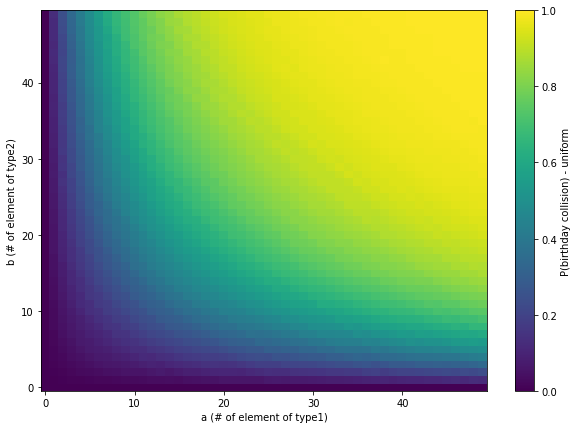

In [179]:
fig, ax = plt.subplots(figsize=(10,7))

c = ax.pcolor(range(50), range(50), zdata, vmin=0, vmax=1)

ax.set_xlabel("a (# of element of type1)")
ax.set_ylabel("b (# of element of type2)")
fig.colorbar(c, ax=ax, label="P(birthday collision) - uniform")
fig.savefig("res/p_uniform_multi.png")
fig.show()

In [ ]:
probabilities, intervals = test_probability_multiple_times(50, 50, 365, real=True)

zdata = np.zeros(shape=(50,50))
for i in range(0, 50):
    for j in range(0, 50):
        zdata[i,j] = probabilities[(i, j)]

fig, ax = plt.subplots(figsize=(10,7))

c = ax.pcolor(range(50), range(50), zdata, vmin=0, vmax=1)

ax.set_xlabel("a (# of element of type1)")
ax.set_ylabel("b (# of element of type2)")
fig.colorbar(c, ax=ax, label="P(birthday collision) - real")
fig.savefig("res/p_real_multi.png")
fig.show()

C:\Users\david\AppData\Local\Temp\ipykernel_9540\4096316308.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


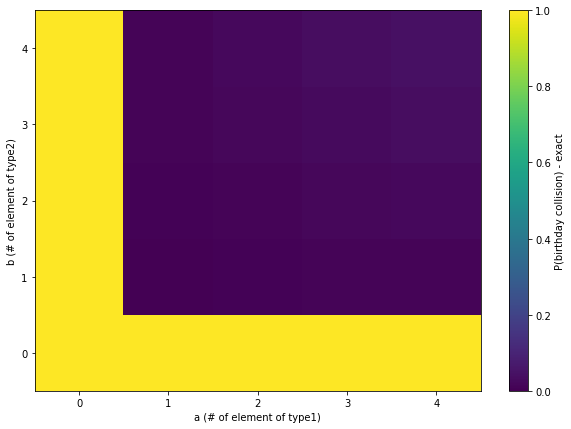

In [19]:
a = 5
b = 5
probabilities, intervals = test_probability_multiple_times(a, b, 365, real=True)

zdata = np.zeros(shape=(a,b))
for i in range(0, a):
    for j in range(0, b):
        zdata[i,j] = expected_p_multiple_types(i, j, 365)

fig, ax = plt.subplots(figsize=(10,7))

c = ax.pcolor(range(a), range(b), zdata, vmin=0, vmax=1)

ax.set_xlabel("a (# of element of type1)")
ax.set_ylabel("b (# of element of type2)")
fig.colorbar(c, ax=ax, label="P(birthday collision) - exact")
fig.savefig("res/p_exact_multi.png")
fig.show()

In [1]:
a, b = 30,30
zdata = np.zeros(shape=(a,b))
for i in range(a):
    for j in range(b):
        zdata[i,j] = expected_p_multiple_types(i,j,365)



NameError: name 'np' is not defined

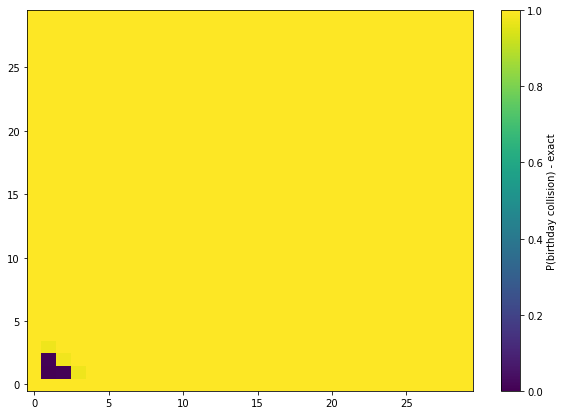

In [69]:
fig, ax = plt.subplots(figsize=(10,7))

c = ax.pcolor(range(a), range(b), zdata, vmin=0, vmax=1)
fig.colorbar(c, ax=ax, label="P(birthday collision) - exact")

In [61]:
c=[2,3,4]
np.prod(c)

24

In [14]:
# compute results and plot

probabilities_uniform, intervals_uniform = test_probability(100, 365, real=False)
probabilities_real, intervals_real = test_probability(100, 365, real=True)

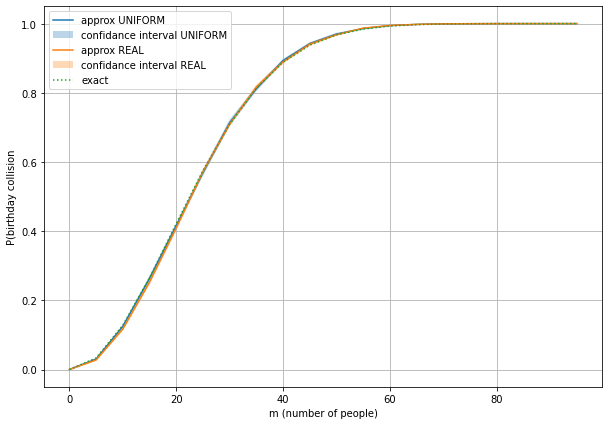

In [15]:
plt.figure(figsize=(10,7))
plt.plot(range(0,100,5), probabilities_uniform, label="approx UNIFORM")
y1 = []
y2 = []
for i in range(len(intervals_uniform)):
    y1.append(intervals_uniform[i][0])
    y2.append(intervals_uniform[i][1])

plt.fill_between(x=range(0,100,5), y1=y1, y2=y2, alpha=.3, label="confidance interval UNIFORM")

plt.plot(range(0,100,5), probabilities_real, label="approx REAL")
y1 = []
y2 = []
for i in range(len(intervals_real)):
    y1.append(intervals_real[i][0])
    y2.append(intervals_real[i][1])

plt.fill_between(x=range(0,100,5), y1=y1, y2=y2, alpha=.3, label="confidance interval REAL")

x = [ expected_p(i, 365) for i in range(0, 100, 5) ]
plt.plot(range(0, 100, 5), x, linestyle=":", label="exact")

plt.legend()
plt.xlabel("m (number of people)")
plt.ylabel("P(birthday collision")
plt.grid()
plt.savefig("res/p_real_vs_uniform.png")
plt.show()

In [16]:
# compute results and plot

d_probabilities = {}
d_intervals = {}
for n in [100, 365, 500, 1000, 2000]:
    probabilities_uniform, intervals_uniform = test_probability(100, n, real=False)
    d_probabilities[n] = probabilities_uniform
    d_intervals[n] = intervals_uniform

# TO-DO plot

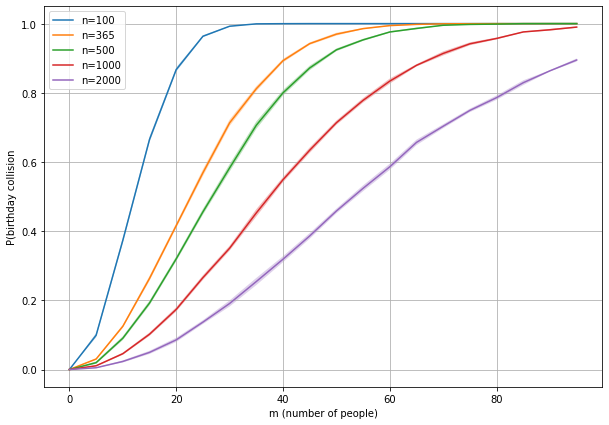

In [17]:
plt.figure(figsize=(10,7))
r = range(0, 100, 5)
for k, v in d_probabilities.items():
    plt.plot(r, v, label=f"n={k}")
    y1 = []
    y2 = []
    for i in range(len(d_intervals[k])):
        y1.append(d_intervals[k][i][0])
        y2.append(d_intervals[k][i][1])
    plt.fill_between(x=r, y1=y1, y2=y2, alpha=.3)

plt.legend()
plt.xlabel("m (number of people)")
plt.ylabel("P(birthday collision")
plt.savefig("res/p_different_n.png")
plt.grid()
plt.show()

In [18]:
# compute results and plot

averages_uniform, intervals_uniform = test_average(1500, real=False)

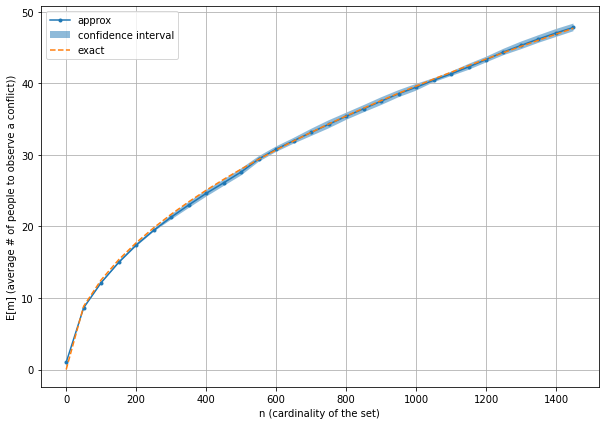

In [19]:
plt.figure(figsize=(10,7))
plt.plot(range(0,1500,50), averages_uniform, marker=".", label="approx")

y1 = []
y2 = []
for i in range(len(intervals_uniform)):
    y1.append(intervals_uniform[i][0])
    y2.append(intervals_uniform[i][1])

plt.fill_between(x=range(0,1500,50), y1=y1, y2=y2, alpha=.5, label="confidence interval")

x = [expected_Em(i) for i in range(0, 1500, 50)]
plt.plot(range(0, 1500, 50), x, linestyle="--", label="exact")

plt.xlabel("n (cardinality of the set)")
plt.ylabel("E[m] (average # of people to observe a conflict))")
plt.grid()
plt.legend()
plt.savefig("res/Em.png")
plt.show()